# Capstone Project: Predicting Patient No-Shows

## Introduction

- In this project, I investigate a data set of appointment records in public hospitals in Vitoria, Espirito Santo, Brazil. The data includes whether the patient showed up to the appointment, which is the main focus, as well as other attributes of the patient and the appointment. My main question is: how likely is a patient with certain attributes, to show up to his hospital appointment?

- To answer this question, I first do clean the data and explore exploratory analysis. I then train classification models using DecisionTree, a RandomForest, a linear SVM, an SVM with a radial basis kernel, AdaBoost. Finally, I resemble and blend models to predict the target variable. By comparing models' AUC and accuracy, I identify the best model in predicting patient no-shows.


## Part I: Dataset Loading & Pre-processing

- I start with reading the data set, checked out for the outliers and the missing values in our data set.

In [1]:
# Import library

import pandas as pd
import numpy as np
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings ## To ignore the warnings

from numpy import hstack

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion, make_union
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder,LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

!pip install xgboost
!pip install sklearn_pipeline_utils
!pip install sklearn_pandas

warnings.filterwarnings('ignore')

In [2]:
## Reference for downloading the data set : https://www.kaggle.com/joniarroba/noshowappointments

df = pd.read_csv("KaggleV2-May-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Seperating training and test data with stratified sampling

split = StratifiedShuffleSplit(n_splits=1, test_size=0.189, random_state=1234)
for train_index, test_index in split.split(df, df["No-show"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [4]:
# Saving the train and test sets

train_set.to_csv("Trainingdata.csv",index=False)
test_set.to_csv("Testdata.csv",index=False)

In [5]:
## Define the independent and dependent variables

X=train_set.loc[:, train_set.columns != 'No-show'] # It will contains all columns except our target column
Y=train_set.loc[:, train_set.columns == 'No-show'] #It will contain target column

In [6]:
# Remove records with erroneous entries

def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

In [7]:
get_percentage_missing(df)

PatientId         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
Neighbourhood     0.0
Scholarship       0.0
Hipertension      0.0
Diabetes          0.0
Alcoholism        0.0
Handcap           0.0
SMS_received      0.0
No-show           0.0
dtype: float64

## Part II: Data Visualization

- I explore data visualization, checking data distribution and data attributes. 

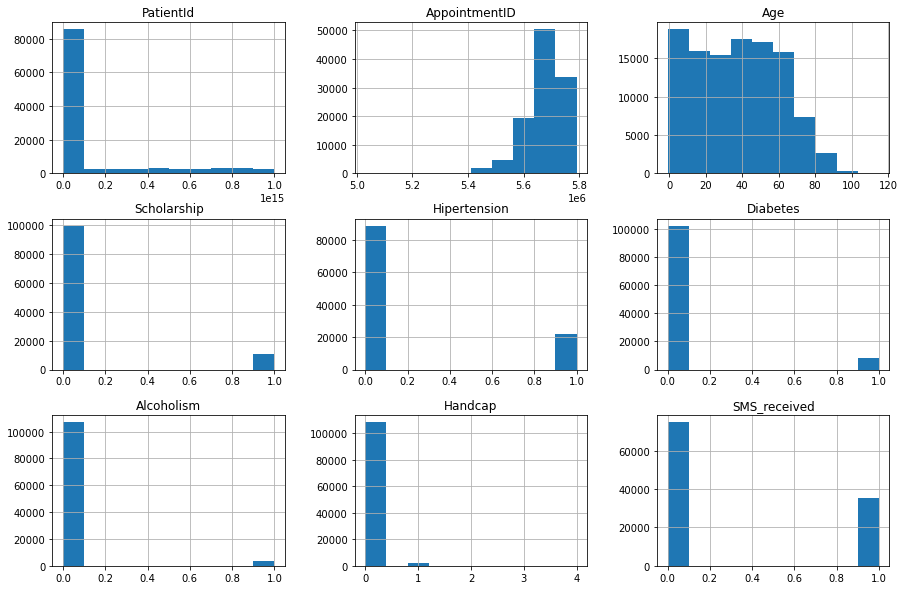

In [8]:
# Plotting all the numeric columns to get an idea of their data distribution

import matplotlib.pyplot as plt
df.hist(layout=(3,3), figsize=(15,10))

plt.show()

- We will not be considering PatientID and Appointment ID in our training columns, as our data samples are independent and identically distributed so we can remove the sample IDs. It is given that all samples come from or refer to the same source/object and they don't somehow identify the sample class.

In [9]:
# Exclude PatientId & AppointmentID

df.pop('PatientId')
df.pop('AppointmentID')

0         5642903
1         5642503
2         5642549
3         5642828
4         5642494
           ...   
110522    5651768
110523    5650093
110524    5630692
110525    5630323
110526    5629448
Name: AppointmentID, Length: 110527, dtype: int64

In [10]:
# Replace age that is less than zero or greater than a certain number to  NaN

df['Age'] = df['Age'].mask(df['Age'].sub(df['Age'].mean()).div(df['Age'].std()).abs().gt(2))

In [11]:
# Converting target categorical column to numeric column

from sklearn.preprocessing import LabelEncoder
y_converted = LabelEncoder().fit_transform(np.ravel(Y))

In [12]:
# numerical features

num_cols = X.select_dtypes([int, float]).columns

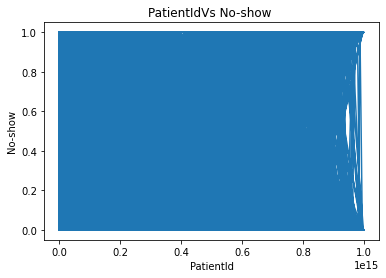

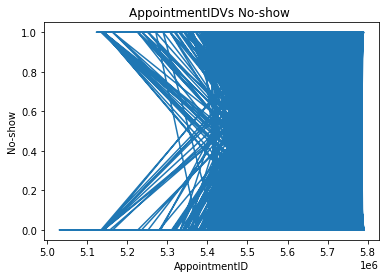

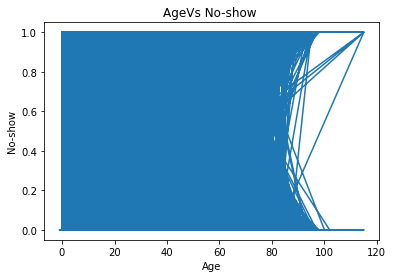

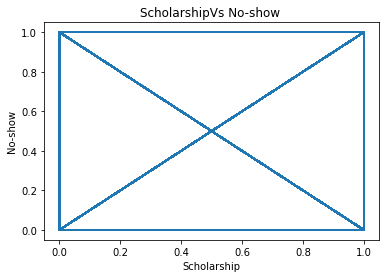

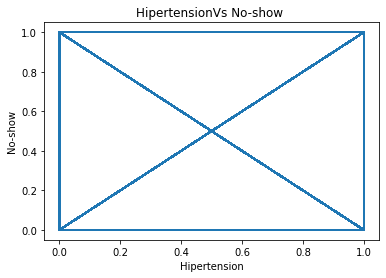

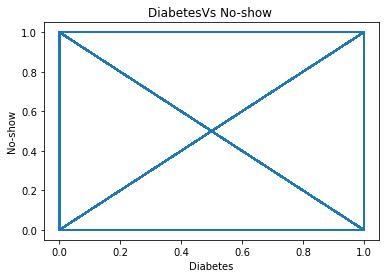

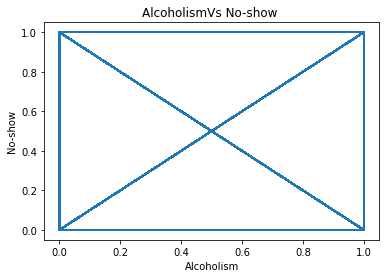

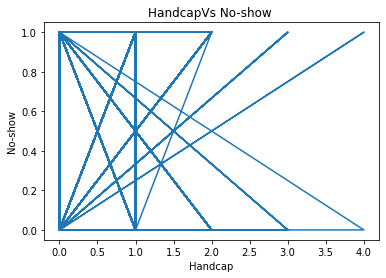

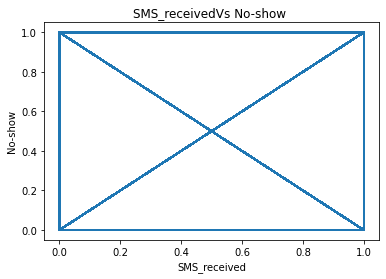

In [13]:
# Plot No-show variable against numerical features

for i in num_cols:
    plt.plot(X[i],y_converted)
    plt.title(i+"Vs No-show ")
    plt.xlabel(i+"")
    plt.ylabel("No-show")
    plt.show()

## Part III: Training , Comparing Models Performance

- For the evaluation of the classifier built, I use Accuracy as the metric. I test it on different folds using k-fold cross-validation. For each model, I make the confusion matrix and an accuracy plot.

In [14]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean', to_fill_with='NA'):
        self.method = method
        self.fill = to_fill_with

    def fit(self, X, y=None):
        if self.method in ['mean', 'median']:
            if not all([dtype in [np.number, np.int] for dtype in X.dtypes]):
                raise ValueError('Only mean median and mode method is supported')
        if self.method == 'mean':
            self.fill = X.mean()
        elif self.method == 'median':
            self.fill = X.median()
        elif self.method == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.method == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname, v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [15]:
## Making a pipeline for numerical data

numerical_data_pipeline = DataFrameMapper(
        [(X.select_dtypes([int, float]).columns,
        CustomImputer(method='median'), {'alias': 'numerical_data'}
        )    
        ],input_df=True ,df_out=True)



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaled_numerical_pipeline = make_pipeline(
    numerical_data_pipeline,
    StandardScaler(),
    MinMaxScaler()
)

In [16]:
numerical_data_pipeline.fit_transform(X)

,numerical_data_0,numerical_data_1,numerical_data_2,numerical_data_3,numerical_data_4,numerical_data_5,numerical_data_6,numerical_data_7,numerical_data_8
64781,7.689156e+11,5545766,35,0,0,0,0,0,1
33727,8.781385e+12,5686794,52,1,0,0,0,0,0
13711,3.716832e+13,5616637,12,0,0,0,0,0,0
104875,5.979859e+10,5773063,50,0,0,0,0,0,0
51299,9.486152e+12,5529988,17,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
94003,2.979784e+13,5764895,0,0,0,0,0,0,0
20314,1.736887e+14,5663006,18,0,0,0,0,0,0
83679,1.358535e+14,5589464,71,0,0,1,0,0,0
50014,3.355592e+13,5630383,36,0,0,0,0,0,0


In [17]:
impute_mode_cols = gen_features(
    columns=X.select_dtypes('object').columns,
    classes=[
        {'class':CustomImputer,'method':'mode'},
        {'class':LabelEncoder}
    ]
)

In [18]:
categorical_data_pipeline = make_union(
    DataFrameMapper(impute_mode_cols, input_df=True, df_out=True)
)
categorical_data_pipeline.fit_transform(X)

array([[    0,  4137,     2,    38],
       [    0, 45699,    10,    36],
       [    0, 13767,    16,    24],
       ...,
       [    1,  8570,     4,    36],
       [    0, 17503,    13,    39],
       [    0, 35022,     5,    23]])

In [19]:
# Final pipeline for pre-processing features

features_pipeline = make_union(scaled_numerical_pipeline, 
                      categorical_data_pipeline)

In [20]:
final_X = features_pipeline.fit_transform(X)

In [21]:
final_dataframe = pd.concat([ pd.DataFrame(y_converted),pd.DataFrame(final_X)] ,axis=1)

In [22]:
final_dataframe.to_csv("Trainingdata.csv",index=False)

In [23]:
# Read training data

traindf = pd.read_csv("Trainingdata.csv")

In [24]:
# Seperating the independent and dependent variables

X_train=traindf.loc[:, traindf.columns != '0'] # It will contains all columns except our target column
y_train=traindf.loc[:, traindf.columns == '0'] #It will contain target column

In [25]:
# K Fold cross validation

def k_fold_cross_validation(training_columns, labels, Classifier, name_of_model): 
 

    kf = KFold( shuffle=True,n_splits=10)# Initializing KFold object with 10 as k-value
    accs=[]
    training_columns_train_array = []
    labels_train_array = []
    training_columns_test_array = []
    labels_test_array = []
    iter = 0
    print("Applying K fold cv algorithm for :", (name_of_model))
    for training_indices, test_indices in kf.split(training_columns):
        iter += 1
        print("iter ", iter)
        training_columns_train_cv, labels_train_cv = training_columns.iloc[training_indices], labels.iloc[training_indices]
        training_columns_test_cv, labels_test_cv = training_columns.iloc[test_indices], labels.iloc[test_indices]
        training_columns_train_array.append(training_columns_train_cv) # adding training score for  the given iteration
        training_columns_test_array.append(training_columns_test_cv) # adding test score for iteration
        labels_train_array.append(labels_train_cv)  # adding training labels for  the given iteration
        labels_test_array.append(labels_test_cv)  # adding test labels for  the given iteration
        print("Shape of training training_columns: ", training_columns_train_cv.shape)
        print("Shape of test training_columns: ", training_columns_test_cv.shape)
        Classifier.fit(training_columns_train_cv, labels_train_cv) 
        preds = Classifier.predict(training_columns_test_cv)
        score = accuracy_score(preds, labels_test_cv) # Calculating acc
        accs.append(score) # adding k-fold  acc for each iter
    print("List of k-fold  accs for {}: ".format(name_of_model), accs)
    average_acc = np.mean(accs)
    print("\nAverage k-fold  acc for {}: ".format(name_of_model), average_acc)
    print("\nBest k-fold  acc for {}: ".format(name_of_model), max(accs))
    maximum_acc_index = accs.index(max(accs)) # best k-fold  acc
    maximum_acc_training_columns_train = training_columns_train_array[maximum_acc_index] # training training_columns corresponding to best k-fold  acc
    maximum_acc_training_columns_test = training_columns_test_array[maximum_acc_index] # test training_columns corresponding to best k-fold  acc
    maximum_acc_labels_train = labels_train_array[maximum_acc_index] # training labels corresponding to best k-fold  acc
    maximum_acc_labels_test = labels_test_array[maximum_acc_index] # test labels corresponding to best k-fold  acc

    return average_acc, maximum_acc_training_columns_train, maximum_acc_training_columns_test, maximum_acc_labels_train, maximum_acc_labels_test,accs

In [26]:
# Visualize the performance of each Classifier, we will be noting its accuracy

def evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, targets, regr): 
    regr.fit(max_acc_data_train, max_acc_targets_train) #
    targets_pred = regr.predict(max_acc_data_test) # Prediction on test data
    
    print("roc_auc_score")
    rep = roc_auc_score(max_acc_targets_test, targets_pred)
    print(rep)

In [27]:
# Simple Classification models with default parameters

clf = DecisionTreeClassifier(min_impurity_decrease=0.4) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "DT") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : DT
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674,

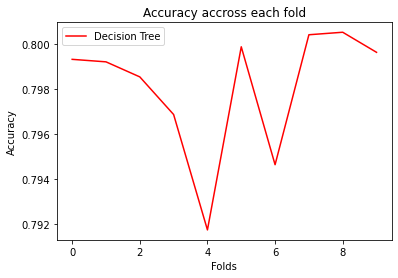

In [28]:
# plot to compare accuracy values
plt.plot(dt_scores,color='r',label="Decision Tree")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

In [29]:
clf = RandomForestClassifier(min_impurity_decrease=0.3) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "RF") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : RF
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674,

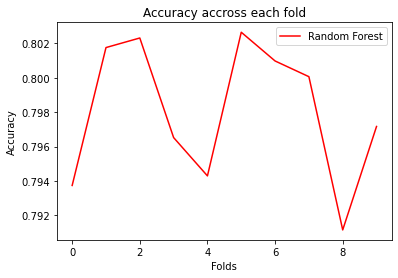

In [30]:
# plot to compare accuracy values
plt.plot(dt_scores,color='r',label="Random Forest")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

In [31]:
clf = LinearSVC() #  Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "LinearSVC") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : LinearSVC
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  

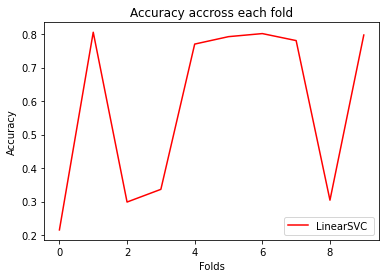

In [32]:
# plot to compare accuracy values

plt.plot(dt_scores,color='r',label="LinearSVC ")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

In [33]:
clf = SVC(kernel='rbf') #  Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train[:100000], y_train[:100000], clf, "SVC") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : SVC
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674

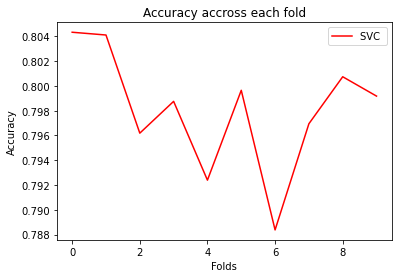

In [34]:
# plot to compare accuracy values

plt.plot(dt_scores,color='r',label="SVC ")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

**Reporting estimated performances:**

| Classifier | AUC score | Accuracy |
| --- | --- | --- |
| RF | .56 | .79 |
| DT | .60 | .73 |
| Linear SVC | .5 | .80 |
| Rbf SVC | .5 | .80 |

## Part IV : Hyperparameter Tuning

- I fine-tune these models and compared their performances with other models.

In [35]:
model = DecisionTreeClassifier()

min_impurity_decreases = [0.1,0.5,0.8]
max_depths = [None, 5, 10, 15]
max_leaf_Nodes = [None, 10,100]

In [36]:
# define grid search

grid = dict(min_impurity_decrease=min_impurity_decreases,max_depth=max_depths,max_leaf_nodes=max_leaf_Nodes)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)

In [37]:
# summarize results

print("Best: parameters %s" % ( grid_result.best_params_))

Best: parameters {'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1}


In [38]:
# Create the parameter grid based on the results of random search 

param_grid = {
    'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 300]
}

In [39]:
# Create a based model

rf = RandomForestClassifier()

In [40]:
# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)

In [41]:
# Fit the grid search to the data

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [42]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=None, min_impurity_decrease=0.1) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "DT") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : DT
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674,

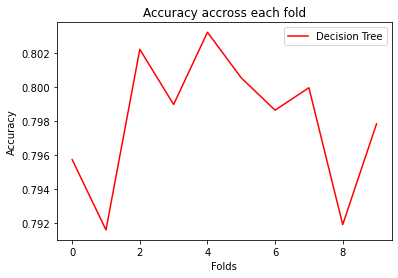

In [43]:
# Plot to compare accuracy

plt.plot(dt_scores,color='r',label="Decision Tree")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

In [44]:
clf = RandomForestClassifier(max_depth=80,
 max_features=3,
 min_samples_leaf=3,
 min_samples_split=10,
 n_estimators=100) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "RF") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : RF
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674,

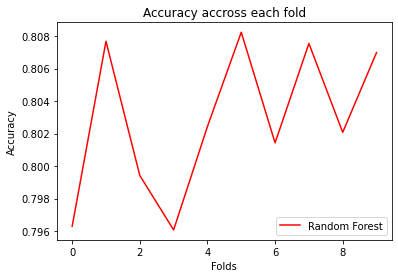

In [45]:
# Plot to compare accuracy

plt.plot(dt_scores,color='r',label="Random Forest")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

**Estimated performance for the tuned classifiers**

| Classifier | AUC score | Accuracy |
| --- | --- | --- |
| RF | .52 | .80 |
| DT | .5 | .80 |


In [46]:
# Implement gradient descent for a linear svm

class svc:
    def __init__(self , C = 0.01 , number_of_iterations = 100 , learning_rate = 0.1):
 
        self.c = C
        self.iteration = number_of_iterations
        self.lr = learning_rate
            
    def fit(self , x , y):
        self.x = x
        self.y = y
        
        w = np.zeros([1 , x.shape[1]])
        b = 0
        
        costs = np.zeros(self.iteration)
        for i in range(self.iteration):
            cost = x @ w.T + b
            b = b - self.lr * self.c * sum(cost - y) 
            w = w - self.lr * self.c * sum((cost - y)*x) 
            costs[i] = self.c * sum( (y * cost)  + (1 - y)*cost ) + (1/2)* sum(w.T**2)
        
        self.w = w
        self.b = b 
        self.costs = costs
        
    
    def predict(self , x_test):
        pred_y =  []
        svc = x_test @ self.w.T + self.b
        for i in svc:
            if i >= 0:
                pred_y.append(1)
            else:
                pred_y.append(0)
        
        return pred_y

In [47]:
clf = svc()

clf.fit(X_train.values, y_train.values.reshape([len(y_train) , 1]))

In [48]:
preds = clf.predict(X_train.values)
print("Accuracy for our custom SVM is",accuracy_score(preds,y_train))

Accuracy for our custom SVM is 0.79806329975345


**Performance Comparison:** We have very similar results for SVM implemented in sklearn and our customized implementation.

## Part V: Ensembles and Final Result

- I train an AdaBoost classifier and compare its performance to previous models. Finally, I decide to train ensemble models to test whether they could outperform every single model.  

In [49]:
# Training an AdaBoost classifier

clf = AdaBoostClassifier() # AD Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "AB") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

Applying K fold cv algorithm for : AB
iter  1
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  2
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  3
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  4
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  5
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  6
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  7
Shape of training training_columns:  (80673, 13)
Shape of test training_columns:  (8964, 13)
iter  8
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  9
Shape of training training_columns:  (80674, 13)
Shape of test training_columns:  (8963, 13)
iter  10
Shape of training training_columns:  (80674,

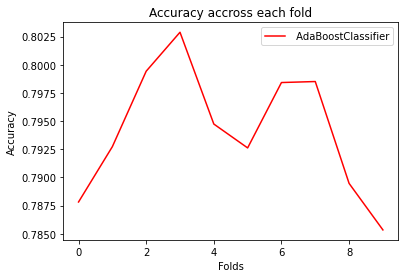

In [50]:
# Plot to compare accuracy

plt.plot(dt_scores,color='r',label=" AdaBoostClassifier")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

In [51]:
# Blending model

def get_classifiers():
    """Function to add the classifiers that we want to keep in our blending model"""
    classifiers = []
    classifiers.append(('lr', LogisticRegression()))
    classifiers.append(('cart', DecisionTreeClassifier()))
    classifiers.append(('Adb', AdaBoostClassifier()))
    classifiers.append(('Rf', RandomForestClassifier()))
    return classifiers

def fit_blending_model(classifiers, X_train_full, y_train_full):
    '''
    This function will perform the following steps:
    1 Creates a validation set using 20% of the training set
    2 Trains each of your chosen classifiers on the training set
    3 Using the validation set creates a new dataset where features are predictions made by each of your chosen classifiers
    4 Trains a logistic regression classifier to blend the predictions
    '''
    # split training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)


    # fit all classifiers on the training set and predict on hold out set
    new_features = list()
    for name, model in classifiers:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        y_preds = model.predict(X_val)
        # reshape predictions into a matrix with one column
        y_preds = y_preds.reshape(len(y_preds), 1)
        # store predictions as input for blending
        new_features.append(y_preds)
    # create 2d array from predictions, each set is an input feature
    new_features = hstack(new_features)
    # define blending model
    clf_blender = LogisticRegression()
    # fit on predictions from base classifiers
    clf_blender.fit(new_features, y_val)
    return clf_blender

def prediction_using_blending(classifiers, clf_blender, X_test):
    # make predictions with base classifiers
    new_features = list()
    for name, model in classifiers:
        # predict with base clf
        y_preds = model.predict(X_test)
        y_preds = y_preds.reshape(len(y_preds), 1)
        new_features.append(y_preds)
    new_features = hstack(new_features)
    # predict
    return clf_blender.predict(new_features)

In [53]:
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

# create the base classifiers
classifiers = get_classifiers()

# train the blending ensemble
clf_blender = fit_blending_model(classifiers, X_train_full, y_train_full)

# make predictions on test set
y_preds = prediction_using_blending(classifiers, clf_blender, X_test)

# evaluate predictions
score = roc_auc_score(y_test, y_preds)
acc = accuracy_score(y_test, y_preds)

print('Blending AUC score: %.3f' % (score))
print('Blending Accuracy: %.3f' % (acc))

Blending AUC score: 0.537
Blending Accuracy: 0.804


## Conclusion

- Through this analysis, the Decision Tree method yields the highest AUC, while three models (Linear SVC, Random Forest, Blending) have the highest Accuracy. Considering both measurements, it looks like the Resembling model would stand out because of its performance relatively well in both measurements. The comparison of all models are below: 

| Classifier | AUC score | Accuracy |
| --- | --- | --- |
| RF | .5 | .79 |
| DT | .51 | .73 |
| Linear SVC | .5 | .80 |
| Rbf SVC | .5 | .80 |
| RF (With tuned parameters) | .56 | .79 |
| DT (With tuned parameters) | .60 | .73 |
| AdaBoost | .50 | .79 |
| Blending | .53 | .80 |

## Reflection & Improvement

- First, there are still some other methods I want to try, for example, I can combine unsupervised learning and supervised learning to see if it can boost the performance. On the other hand, I can build up some other base models such as using neural networks and then using the ensemble method to build some higher-level stacking model.

- Second, the model assessment is based on a binary outcome variable, no-shows. In many situations, outcomes can be much more complicated. So further training would be needed to test scenarios where outcomes are categorical data or continuous data. 

- Finally, I use static data but in real life, data is accumulating daily. How this changing data impact our model selection and assessment, is yet another topic I'd like to explore in the future. 